# Version 3

In This Version the main focus will be to try out different architectures and see if we can improve the accuracy.

I'll also be making the code more modular and will improve the intigration with helper functions.

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchinfo import summary

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import pathlib
import sys

from functools import partial

In [2]:
cuda_available = torch.cuda.is_available()
mps_available = torch.backends.mps.is_available()

device = torch.device("cpu")                # For CPU The Default Device
if cuda_available:
    device = torch.device("cuda:0")
elif mps_available:
    device = torch.device("mps")
    
print("Device:", device)

Device: mps


In [3]:
is_local = True
version = 2

PROJECT_PATH =  pathlib.Path(".") / "MNIST-Digit 8k params"

weights_path = PROJECT_PATH / 'weights/version_3'

## Data

### Load MNIST data

In [4]:
train_data = datasets.MNIST(
    root=PROJECT_PATH, 
    train=True, 
    download=True,
    transform=transforms.ToTensor()
)
test_data = datasets.MNIST(
    root=PROJECT_PATH, 
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

print("Length of train data: ", len(train_data))
print("Length of test data: ", len(test_data))

Length of train data:  60000
Length of test data:  10000


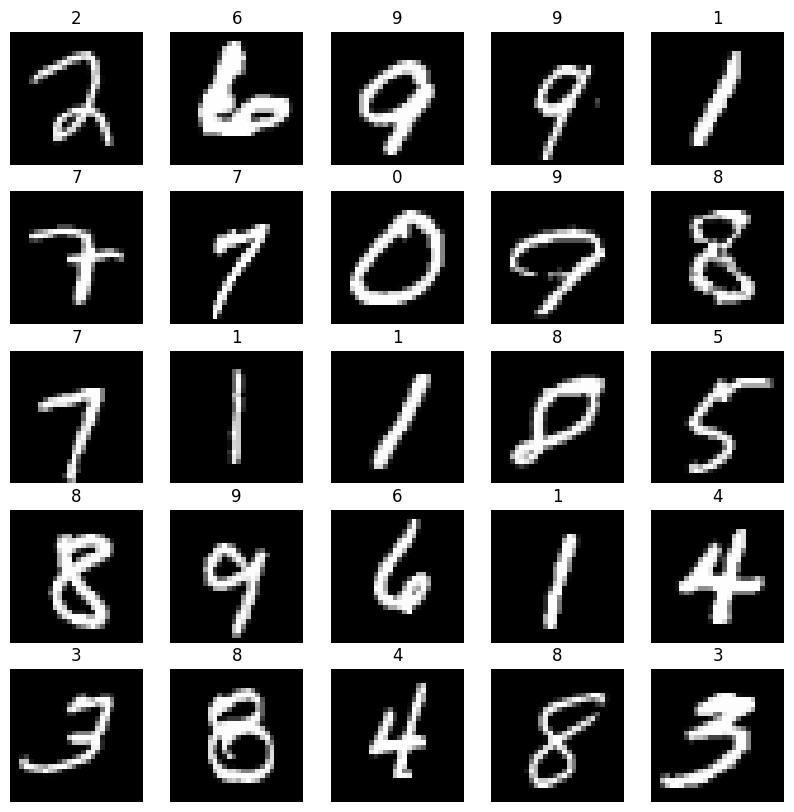

In [5]:
figure = plt.figure(figsize=(10, 10))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [6]:
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader  = DataLoader(test_data,  batch_size=64, shuffle=False)

## MODEL

### Networks

Let's initalize the base class for the network and Block class for the layers. Since I'll be experimenting with different architectures, This will reduce the amount of code I have to write.

In [7]:
# Learning from previous version, we'll be using the following:
# 1. BatchNorm2d
# 2. LeakyReLU (after BN)
class ConvBlock(nn.Module):
    def __init__(
        self, 
        in_channels: int, 
        out_channels: int,
        kernel_size: int = 3,
        stride: int = 1,
    ):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size)
        self.bn = nn.BatchNorm2d(out_channels)
        self.lrelu = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.lrelu(x)
            
        return x
        

class DepthwiseConvBlock(nn.Module):
    def __init__(
        self, 
        in_channels: int, 
        out_channels: int,
        kernel_size: int = 3,
        stride: int = 1,
    ):
        super(DepthwiseConvBlock, self).__init__()
        self.depth_wise_conv = nn.Conv2d(in_channels, in_channels, kernel_size, groups=in_channels)
        self.point_wise_conv = nn.Conv2d(in_channels, out_channels, 1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.lrelu = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        x = self.depth_wise_conv(x)
        x = self.point_wise_conv(x)
        x = self.bn(x)
        x = self.lrelu(x)
            
        return x

class BaseNetwork(nn.Module):
    def __init__(self):
        super(BaseNetwork, self).__init__()

    def forward(self, x):
        raise NotImplementedError
    
    def summary(self, verbose: int=1, **kwargs):
        """
        Prints the summary of the model.
        """
        # Num params
        num_params = sum([np.prod(p.size()) for p in self.parameters()])
        print(f"Number of parameters: {num_params}")
        summary(
            self,
            input_size=(1, 28, 28),
            batch_dim=0,
            col_names = ("input_size", "output_size", "num_params", "kernel_size"),
            verbose = verbose,
            **kwargs
            )


### Training Loop
<!-- I'm going with my useual 1st prefrences
- Adam Optimizer
- Cross Entropy Loss

They often give the best results and are 1st choice for most people. -->

In [8]:
divmod(12345, 60)

(205, 45)

In [9]:
from torch.autograd import Variable
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import copy
import time

def train(
    num_epochs, 
    network, 
    train_loader, 
    val_loader, 
    loss_func, 
    optimizer, 
    device="cpu",
    scheduler=None,
    callbacks: dict=None,
):
    network = network.to(device)
    network.train()
    logs = {}
    total_step = len(train_loader)
    print(f"Training on {device} ")
    
    for epoch in range(num_epochs):
        t_epoch_start = time.time()
        network.train()
        
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            # forward & back prop
            outputs = network(images)
            
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()
            
            if i == 0:
                print(f"Epoch {epoch+1}/{num_epochs} (", end="")
                
            if (i+1) % (total_step//40) == 0:
                print("#", end="")
        
        t = time.time() - t_epoch_start
        # Eveluate
        print(f")\tTime: {t:.2f}s")
        train_loss, train_metrics, _, _ = evaluate(network, train_loader, loss_func, device)
        val_loss, val_metrics, _, _ = evaluate(network, val_loader, loss_func, device)
        print(f"Train loss: {train_loss:.4f} | Val loss: {val_loss:.4f}")
        logs[epoch] = {
            "train_loss": train_loss,
            "val_loss": val_loss,
        }
        for metric, value in train_metrics.items():
            logs[epoch][f"train_{metric}"] = value
            logs[epoch][f"val_{metric}"] = val_metrics[metric]
            
            print(f"Train {metric}: {value:.4f} | Val {metric}: {val_metrics[metric]:.4f}")
            
            
        # logs[epoch] = {
        #     "train_loss": train_loss,
        #     "train_metrics": train_metrics,
        #     "val_loss": val_loss,
        #     "val_metrics": val_metrics,
        # }
        
        # Callbacks
        if scheduler:
            scheduler.step()
            
        if callbacks:
            for callback in callbacks:
                callback(
                    epoch=epoch,
                    network=network,
                    logs=logs,
                    train_loss=train_loss,
                    train_metrics=train_metrics,
                    val_loss=val_loss,
                    val_metrics=val_metrics,
                )
    
        if epoch == 0:
            total_aprox_time = (time.time() - t_epoch_start) * (num_epochs - 1)
            m, s = divmod(total_aprox_time, 60)
            h, m = divmod(m, 60)
            print(f"Approx. time remaining: {h:.0f}h {m:.0f}m {s:.0f}s")
            
    return logs
    

def evaluate(
    network, 
    data_loader, 
    loss_func=None, 
    device="cpu", 
    metrics:list=None
):
    network.eval()
    loss = 0
    original = []
    predicted = []
    
    if loss_func is None:
        loss_func = nn.CrossEntropyLoss()
    if metrics is None:
        metrics = [accuracy_score]
    
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            output = network(images)
            loss += loss_func(output, labels).item()

            original += labels.to("cpu").tolist()
            predicted += torch.argmax(output, dim=1).to("cpu").tolist()
    
    metrics = {metric.__name__: metric(original, predicted) for metric in metrics}
    
    return loss, metrics, original, predicted


In [10]:
# All Callbacks
# Logging
def log_model_performance(model_dir, logs, **kwargs):
    logs_df = pd.DataFrame(logs).T
    os.makedirs(model_dir, exist_ok=True)
    log_path = os.path.join(model_dir, 'logs.csv')
    logs_df.to_csv(log_path, mode='a')
    
# Checkpoint
def save_model(model_dir, epoch, model,  save_after=1,**kwargs):
    save_path = os.path.join(model_dir, f'model/{epoch}.pt')
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    if epoch % save_after == 0:
        torch.save(model.state_dict(), save_path)

# Early Stopping


### Training 

#### Version 2

Let's Start with Version 2 First and see how the newlly added features work.

In [11]:
from torch import optim

class CNNv2(BaseNetwork):
    def __init__(self):
        super(CNNv2, self).__init__()
        # Block 1
        self.block1 = nn.Sequential(
            ConvBlock(1, 8),
            ConvBlock(8, 8),
            nn.MaxPool2d(2, 2),
        )
        # Block 2
        self.block2 = nn.Sequential(
            ConvBlock(8, 16),
            ConvBlock(16, 32),
            nn.MaxPool2d(4, 4),
        )
        self.out = nn.Linear(4*32, 10)
        
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = x.view(x.size(0), -1)
        x = self.out(x)
        return x

model_name = "Version 2"
cnn_v2 = CNNv2()
cnn_v2.summary()

Number of parameters: 7890
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape
CNNv2                                    [1, 1, 28, 28]            [1, 10]                   --                        --
├─Sequential: 1-1                        [1, 1, 28, 28]            [1, 8, 12, 12]            --                        --
│    └─ConvBlock: 2-1                    [1, 1, 28, 28]            [1, 8, 26, 26]            --                        --
│    │    └─Conv2d: 3-1                  [1, 1, 28, 28]            [1, 8, 26, 26]            80                        [3, 3]
│    │    └─BatchNorm2d: 3-2             [1, 8, 26, 26]            [1, 8, 26, 26]            16                        --
│    │    └─LeakyReLU: 3-3               [1, 8, 26, 26]            [1, 8, 26, 26]            --                        --
│    └─ConvBlock: 2-2                    [1, 8, 26, 26]            [1, 8, 24, 24]            --          

In [36]:
model_dir = PROJECT_PATH / "runs" / model_name

callbacks = [
    partial(log_model_performance, model_dir=model_dir),
    partial(save_model, model_dir=model_dir),
]

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_v2.parameters(), lr = 0.004)      # optimizer.param_groups[0]['lr']
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma = 0.4)

num_epochs = 6
history = train(
    num_epochs,
    cnn_v2,
    train_dataloader,
    test_dataloader,
    loss_func,
    optimizer,
    device,
    scheduler,
    callbacks
)

Training on mps 


Epoch 1/6 (########################################)	Time: 31.65s
Train loss: 31.8863 | Val loss: 6.2026
Train accuracy_score: 0.9894 | Val accuracy_score: 0.9874


TypeError: 'str' object is not callable

5th epoch train accuracy: 0.9879833333333333
5th epoch test accuracy: 0.9859


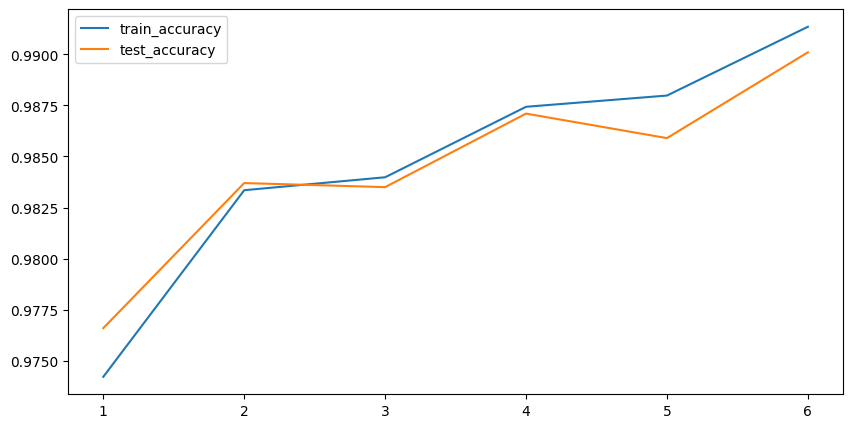

In [23]:
history_df = pd.DataFrame(history).T
history_df

plt.figure(figsize=(10, 5))
plt.plot(history_df.index, history_df['train_accuracy'], label='train_accuracy')
plt.plot(history_df.index, history_df['test_accuracy'], label='test_accuracy')
plt.legend()
print(f"5th epoch train accuracy: {history_df['train_accuracy'][5]}")
print(f"5th epoch test accuracy: {history_df['test_accuracy'][5]}")